## Load and Clean Data

In [ ]:
import pandas as pd
raw = pd.read_csv('yt_data.csv')
raw['len_title'] = [len(i) for i in raw['video_title']]

d = raw['published_date']
y_lst = []
m_lst = []
d_lst = []
for w in d:
    splt = w.split('-', 3)
#     print(w.split('-', 3)[0])
    y_lst.append(splt[0])
    m_lst.append(splt[1])
    d_lst.append(splt[2])

raw['published_year'] = y_lst
raw['published_month'] = m_lst
raw['published_day'] = d_lst
raw['published_year'] = raw['published_year'].astype(int)
raw['published_month'] = raw['published_month'].astype(int)
raw['published_day'] = raw['published_day'].astype(int)

## normalize
raw_norm_col = ['view','commentCount','pos_comments', 'neg_comments', 'q_comments', 'len_title']
df_to_norm = raw[raw_norm_col]
# df_to_norm
df_normed = (df_to_norm-df_to_norm.min())/(df_to_norm.max()-df_to_norm.min())
# df_normed
other_var = ['channel_name', 'video_title', 'nano_ytb', 
             'type_cook', 'type_eat', 'type_unbox', 'type_lottery', 
             'type_car', 'type_life', 'type_travel', 
             'published_year', 'published_month', 'published_day', 'published_date']
df_str_cate = raw[other_var]
df_full = pd.concat([df_normed, df_str_cate], axis=1)

# df_using = df_full #.drop(columns=['channel_name', 'video_title'])
# df_big_ytb = df_using[df_using['nano_ytb']==0]
# df_small_ytb = df_using[df_using['nano_ytb']==1]
# df_small_ytb.head(1)

## Create Label

In [ ]:
def create_good(channel_name):
    channel_75 = df_full[df_full['channel_name']==channel_name]['view'].describe()[-2]   # 75%
    conditions = [ (df_full[df_full['channel_name']==channel_name]['view'] < channel_75),
                   (df_full[df_full['channel_name']==channel_name]['view'] >= channel_75)]
    values = [0, 1]
    return np.select(conditions, values).tolist()

In [ ]:
big1 = '千千進食中'
big2 = '古娃娃WawaKu'
big3 = '路路LULU'
small1 = '啤酒肚唯唯Willow&Andy'
small2 = 'Ting in the Kitchen 今天吃什麼'
small3 = 'Jessica Liu'
good_label = create_good(big1) + create_good(big2) + create_good(big3) + create_good(small1) + create_good(small2) + create_good(small3)
df_full['label_good'] = good_label

In [ ]:
df_full.columns

Index(['view', 'commentCount', 'pos_comments', 'neg_comments', 'q_comments',
       'len_title', 'channel_name', 'video_title', 'nano_ytb', 'type_cook',
       'type_eat', 'type_unbox', 'type_lottery', 'type_car', 'type_life',
       'type_travel', 'published_year', 'published_month', 'published_day',
       'published_date', 'label_good'],
      dtype='object')

In [ ]:
y = df_full['label_good']
X = df_full[['commentCount', 'pos_comments', 'neg_comments', 'q_comments',
       'len_title', 'nano_ytb', 'type_cook',
       'type_eat', 'type_unbox', 'type_lottery', 'type_car', 'type_life',
       'type_travel', 'published_year', 'published_month', 'published_day']]
print(X.shape, y.shape)

(203, 16) (203,)


## Split Data

In [ ]:
# y_all = df_using['view']
# # y_big_ytb = df_big_ytb['view']
# # y_small_ytb = df_small_ytb['view']

# x_all = df_using.drop(columns=['view'])
# x_big_ytb = df_big_ytb.drop(columns=['view'])
# x_small_ytb = df_small_ytb.drop(columns=['view'])

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
def double_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_train, y_train, X_subtrain, y_subtrain, X_valid, y_valid, X_test, y_test

X_train, y_train, X_subtrain, y_subtrain, X_valid, y_valid, X_test, y_test = double_split(X, y)

In [ ]:
X_test.shape

(67, 16)

In [ ]:
from sklearn.model_selection import GridSearchCV
def model_tuning(model, param_grid_input, x_valid, y_valid, scoring_type):
    gs = GridSearchCV(model, param_grid = param_grid_input, scoring=scoring_type)
    gs.fit(x_valid, y_valid)
    best_params = gs.best_params_
    return best_params

In [ ]:
# check imbalanced or not
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.2647058823529412
0.2537313432835821


In [ ]:
# def model_train_rmse(model, x_train, x_test, y_train, y_test):
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
# #     rmse_val = rmse_func(y_pred, y_test)
    
#     return rmse_val

In [ ]:
# def class_model_eval(y_pred, y_true):
#     fp = np.sum((y_pred == 1) & (y_true == 0))
#     tp = np.sum((y_pred == 1) & (y_true == 1))
#     fn = np.sum((y_pred == 0) & (y_true == 1))
#     tn = np.sum((y_pred == 0) & (y_true == 0)) 

#     # Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)
#     accuracy = ( tp + tn ) / ( tp + fn + tn + fp )
#     print('Accuracy:', accuracy)
    
#     # Precision Score = TP / (FP + TP)
#     precision = tp / (fp+tp)
#     print('Precision:', precision)

#     # Recall Score = TP / (FN + TP)
#     recall = tp/(fn+tp)
#     print('Recall:', recall)

#     # F1 Score = 2* Precision Score * Recall Score / (Precision Score + Recall Score)
#     precision = ( tp + tn ) / ( tp + fn + tn + fp )
#     recall = tp / ( fn + tp )
#     f1_score = 2*precision*recall/(precision+recall)
#     print('F-1 score:', f1_score)
#     return accuracy, precision, recall, f1_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import mlxtend
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

### Logistic

bestc 1718.9876869834982 l2
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.62      0.29      0.40        17

    accuracy                           0.78        67
   macro avg       0.71      0.62      0.63        67
weighted avg       0.75      0.78      0.75        67



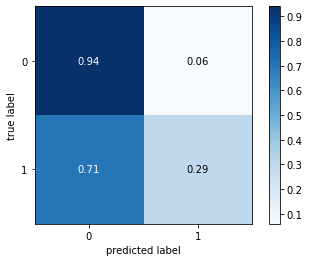

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


grid_list = np.geomspace(1500, 2000, num=20).tolist() 
parameters = {'penalty': ['l2'],
              'C':grid_list}
log_model = LogisticRegression(max_iter = 10000)
gs2 = GridSearchCV(log_model, parameters)
gs2.fit(X_valid, y_valid)

print('bestc', gs2.best_params_['C'], gs2.best_params_['penalty'])

log_bestc =  LogisticRegression(max_iter = 100000, penalty=gs2.best_params_['penalty'], C=gs2.best_params_['C'])
log_bestc.fit(X_train, y_train)

print(classification_report(y_test.tolist(), log_bestc.predict(X_test).tolist()))
cm = confusion_matrix(y_test.tolist(), log_bestc.predict(X_test).tolist())

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

### Random Forest

best_n: 16
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.44      0.24      0.31        17

    accuracy                           0.73        67
   macro avg       0.61      0.57      0.57        67
weighted avg       0.69      0.73      0.70        67



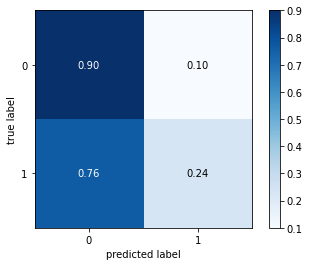

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': 
              np.geomspace(5, 1000, num=10, dtype=int).tolist()}
gs_rf = GridSearchCV(rf_classifier, param_grid = param_grid)
gs_rf.fit(X_valid, y_valid)

print('best_n:', gs_rf.best_params_['n_estimators'])

rf_best = RandomForestClassifier(n_estimators = gs_rf.best_params_['n_estimators'], random_state=42)
rf_best.fit(X_train, y_train)


print(classification_report(y_test.tolist(), rf_best.predict(X_test).tolist()))
cm = confusion_matrix(y_test.tolist(), rf_best.predict(X_test).tolist())

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
f1_lst = []
for lr in [0.1, 0.5, 1]:
    GB_model = GradientBoostingClassifier(n_estimators=100, learning_rate = lr, random_state = 42)
    GB_model.fit(X_train, y_train)
    f1_scores = [f1_score(y_pred, y_valid) for y_pred in GB_model.staged_predict(X_valid)] #in regressor.staged_predict(X_test)] 
    f1_lst.append(f1_scores)
    max_f1 = max(f1_scores)
    print('learning_rate =', lr)
    print('stage_max_f1 =', f1_scores.index(max_f1) + 1)
    print('max_f1 =', max_f1)
    print('---------------------')
# print(f1_lst)

learning_rate = 0.1
stage_max_f1 = 65
max_f1 = 1.0
---------------------
learning_rate = 0.5
stage_max_f1 = 16
max_f1 = 1.0
---------------------
learning_rate = 1
stage_max_f1 = 5
max_f1 = 1.0
---------------------


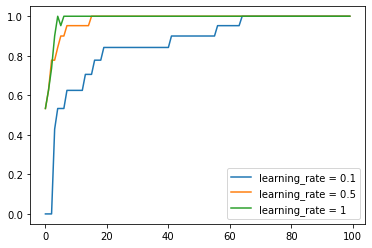

In [ ]:
import matplotlib.pyplot as plt
n_est_list = range(100)
plt.plot(n_est_list, f1_lst[0],
         n_est_list, f1_lst[1],
         n_est_list, f1_lst[2])

#plt.xlabel("stage")
#plt.ylabel("f1_score")
plt.legend(['learning_rate = 0.1', 'learning_rate = 0.5', 'learning_rate = 1'])
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        50
           1       0.50      0.53      0.51        17

    accuracy                           0.75        67
   macro avg       0.67      0.67      0.67        67
weighted avg       0.75      0.75      0.75        67



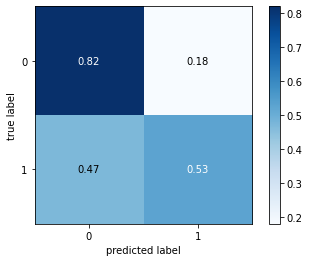

In [ ]:
gb_best = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, random_state = 42)
gb_best.fit(X_train, y_train)

print(classification_report(y_test.tolist(), gb_best.predict(X_test).tolist()))
cm = confusion_matrix(y_test.tolist(), gb_best.predict(X_test).tolist())

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

### MLP

              precision    recall  f1-score   support

           0       0.75      1.00      0.85        50
           1       0.00      0.00      0.00        17

    accuracy                           0.75        67
   macro avg       0.37      0.50      0.43        67
weighted avg       0.56      0.75      0.64        67



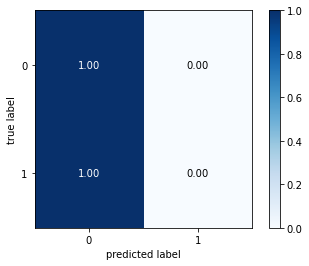

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=10000)
mlp_model.fit(X_train, y_train)
# y_pred = mlp_model.predict(X_test)

print(classification_report(y_test.tolist(), mlp_model.predict(X_test).tolist()))
cm = confusion_matrix(y_test.tolist(), mlp_model.predict(X_test).tolist())

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

### Stacking

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.64      0.41      0.50        17

    accuracy                           0.79        67
   macro avg       0.73      0.67      0.68        67
weighted avg       0.77      0.79      0.77        67



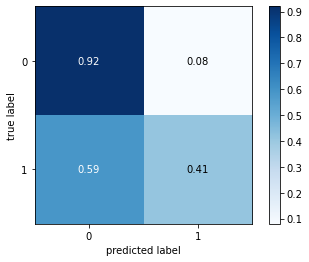

In [ ]:
from sklearn.ensemble import StackingClassifier

ests = [
    ('log', log_bestc),
    ('rf', rf_best),
    ('gb', gb_best),
    ('mlp', mlp_model)
]

stk_model = StackingClassifier(estimators=ests, final_estimator=GradientBoostingClassifier())
stk_model.fit(X_train, y_train)

print(classification_report(y_test.tolist(), stk_model.predict(X_test).tolist()))
cm = confusion_matrix(y_test.tolist(), stk_model.predict(X_test).tolist())

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)